# Environments

Coba Environments are sequences of Interactions. An **Environment** is any class with the following interface:

```python
class Environment:
    def read(self)->Iterable[Interaction]:
        ...
```

Interactions are described in more detail in [Interaction.ipynb](Interactions.ipynb). In this notebook we...

+ ...introduce the Environments API, a friendly interface for creating and modifying collections of environments
+ ...describe several different methods for creating environments using the Environments API
+ ...describe a number of useful environment modifications that can be applied using the Environments API
+ ...describe how the Environments API can be used to generate many environments by applying filters

## Environments API

The **Environments** API creates and manipulates environments via chains of commands. It is accessed via

```python
import coba as cb
cb.Environments
```

There are two types of **Environments** commands. Those that start with `from_` and those that don't.

Every Environments chain starts with a `from_` method. After this any number of filters can be called to modify the environment.

Here is an example
```python
import coba as cb
env = cb.Environments.from_openml(180).reservoir(1000).scale('mean','std').noise(reward=('g',0,.5))
```

This Environments chain will download the Covertype dataset from openml, create an environment from the dataset, use reservoir sampling to select  1000 random examples from the dataset, apply standardization to all context features in the dataset, and then add gaussian noise to all reward values. A more complete list of the chain commands can be found below.

A few more useful details about Environments chains:
+ All Environments chains are Python sequences so they must be indexed to access its contained environment. For example,
```python
import coba as cb
env              = cb.Environments.from_openml(180).reservoir(1000)
env_interactions = list(env[0].read()) #Because cb.Environments always creates a Python sequence we have to index
```

+ All Environments chains are seeded so that the same environment will always be recreated. This means..
```python
env1 = cb.Environments.from_openml(180).reservoir(1000).scale('mean','std')
env2 = cb.Environments.from_openml(180).reservoir(1000).scale('mean','std')

assert list(env1[0].read()) == list(env2[0].read())
```

+ Environment chains can be added together to get a collection of several environments...
```python
import coba as cb
env1 = cb.Environments.from_openml(180).reservoir(1000).scale('mean','std')
env2 = cb.Environments.from_openml(180).reservoir(1000).scale('mean','std')

env = env1+env2

assert len(env) == 2
assert env[0] is env1
assert env[1] is env2
```

+ Many commands on Environment chains take sequences of values and create multiple environments. For example we can...
```python
env = cb.Environments.from_openml(180).reservoir(1000).noise(reward=('g',0,.5),seed=[1,2])

assert len(env) == 2
```

+ The complete list of Environments chain commands can be found in the API reference.


## Environment Creation

Coba has many ways to create environments. The five most common are:

1. From a custom class implementing the Environment interface
2. From an openml.org dataset or task
3. From a local dataset
3. From a synthetic dataset
4. From a result file
5. From a template file

### Environments From Custom Classes

The easiest way to create an environment for simple testing is by creating a custom class. Here are two examples.

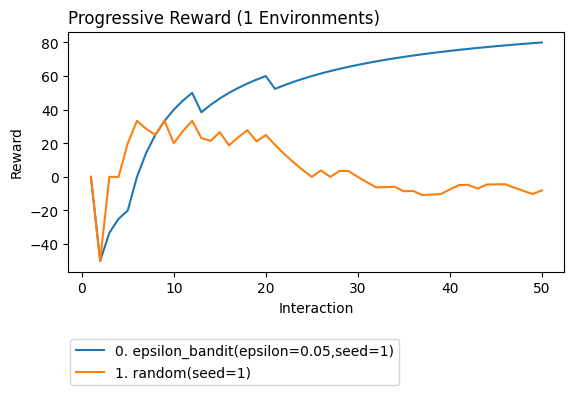

In [1]:
import coba as cb

class BanditEnvironment:    
    def read(self):
        return [ { 'actions':['a','b','c'], 'rewards':[0,100,-100] } ] * 50

environments = cb.Environments.from_custom(BanditEnvironment())
learners     = [cb.EpsilonBanditLearner(),cb.RandomLearner()]
experiment   = cb.Experiment(environments, learners)

experiment.run(quiet=True).plot_learners()

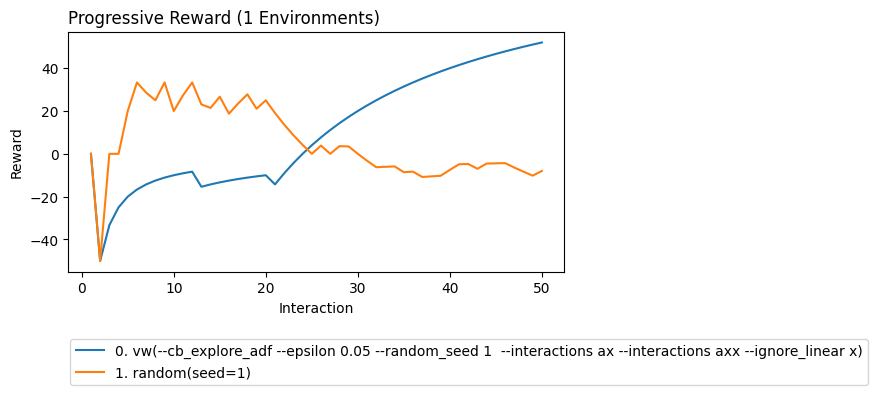

In [2]:
import coba as cb

class ContextualBanditEnvironment:    
    def read(self):
        return [ { 'context':1, 'actions':['a','b','c'], 'rewards':[0,100,-100] } ] * 50

environments = cb.Environments.from_custom(ContextualBanditEnvironment())
learners     = [cb.VowpalEpsilonLearner(),cb.RandomLearner()]
experiment   = cb.Experiment(environments, learners)

experiment.run(quiet=True).plot_learners()

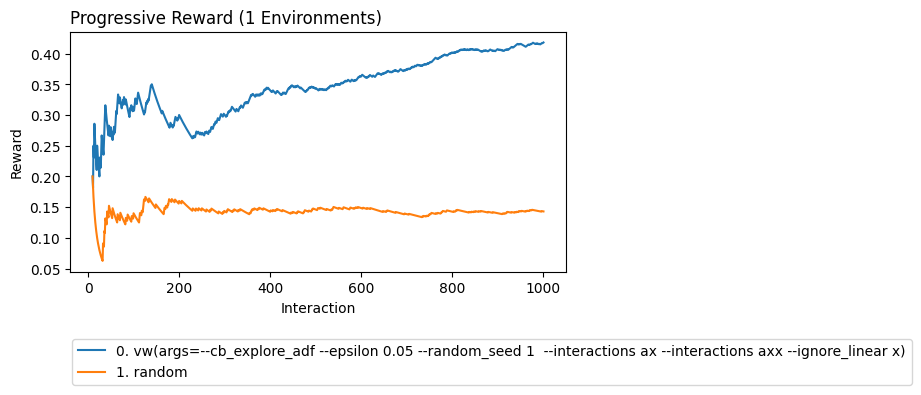

In [4]:
import coba as cb

environments = cb.Environments.from_openml(180).reservoir(1000)
learners     = [cb.VowpalEpsilonLearner(),cb.RandomLearner()]
experiment   = cb.Experiment(environments, learners)

experiment.run(quiet=True).plot_learners(xlim=(10,None))

### Environments From Openml Datasets

Next we can incorporate new Environments by loading them from openml.org. Openml is is an online repository of machine learning data sets which currently hosts over 21,000 datasets. Using either dataset ids or task ids Coba can tap into this repository and download these datasets to create Environments.

To get a sense of how this works let's say we want to build an environment from the Covertype data set. We can [do a dataset search](https://www.openml.org/search?type=data) on openml to see if this data set is hosted. This search finds several datasets and we pick [the one that appears to be original](https://www.openml.org/d/180). On the dataset's landing page we see that its id is 180. Now, all we have to do to run an experiment with the Covertype data set is:

In [1]:
import coba as cb
cb.Environments.from_openml(180)

1. Openml(data=180) | BatchSafe(Finalize)


### Environments From Local Supervised Datasets

Next we can incorporate new environments from local datasets. Coba has built-in support for the following formats:
* CSV
* ARFF (i.e., https://waikato.github.io/weka-wiki/formats_and_processing/arff_stable/)
* Libsvm (e.g., https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html)
* Manik (e.g., http://manikvarma.org/downloads/XC/XMLRepository.html)

For example, we may have the iris dataset saved in `iris.arff` in the arff format. To create an environment from this dataset we can.

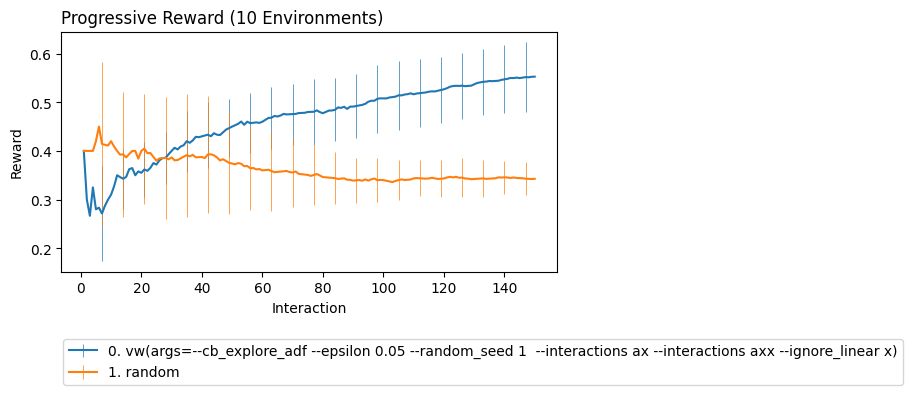

In [6]:
import coba as cb

environments = cb.Environments.from_supervised(cb.ArffSource("iris.arff"), label_col='Species').shuffle(n=10)
learners     = [cb.VowpalEpsilonLearner(),cb.RandomLearner()]
experiment   = cb.Experiment(environments, learners)

experiment.run(quiet=True).plot_learners(err='se')

### Environments From Synthetic Datasets

Coba provides access to several synthetic data generators from many function class families. Coba has built-in support for the following formats:
* Linear -- `cb.Environments.from_linear_synthetic`
* Nearest Neighbors -- `cb.Environments.from_neighbors_synthetic`
* Kernel Methods -- `cb.Environments.from_kernel_synthetic`
* Multilayer Perceptrons -- `cb.Environments.from_mlp_synthetic`

For example, below we create a synthetic dataset whose expected reward function is linear with respect to action features:

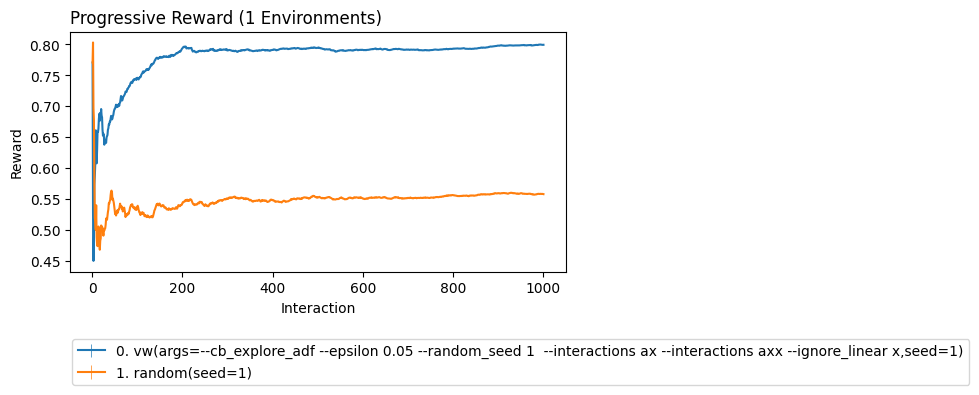

In [2]:
import coba as cb

environments = cb.Environments.from_linear_synthetic(
    n_interactions=1000,
    n_actions=5,
    n_context_features=0,
    n_action_features=5,
    reward_features = ["a"],
    seed=1
)

learners     = [cb.VowpalEpsilonLearner(),cb.RandomLearner()]
experiment   = cb.Experiment(environments, learners)

experiment.run(quiet=True).plot_learners(err='se')

### Environments From Result Files

A more advanced use case is to create environments from the result of previous experiments. This is useful for off-policy experiments.

We give an example below, but this topic is covered in much more detail in the [Logged](./Logged.ipynb) notebook.

 ------------------------------------------------------------------------------
 Create the result file with logged actions and plot the on-policy performance.
 ------------------------------------------------------------------------------


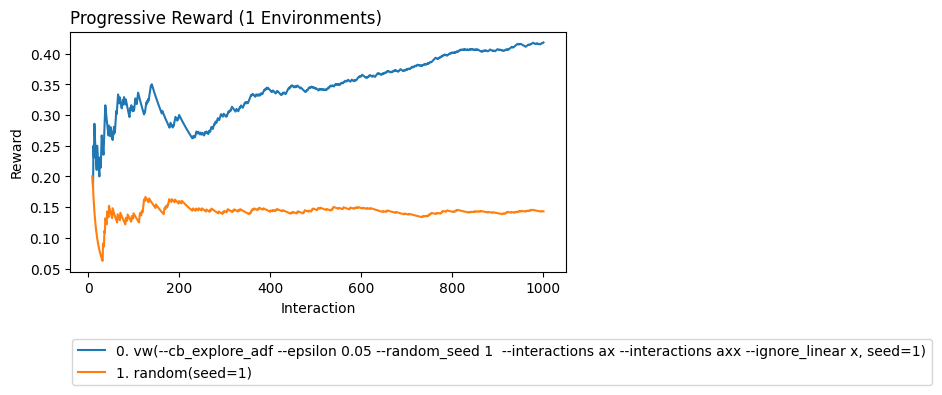

 ------------------------------------------------------------------------------
 Use the result file to create logged bandit data and plot off-policy learning.
 ------------------------------------------------------------------------------


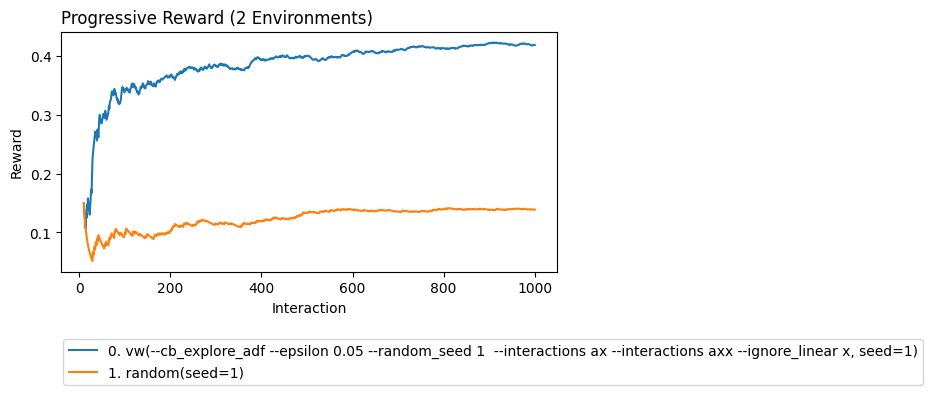

In [18]:
import coba as cb

print(" ------------------------------------------------------------------------------")
print(" Create the result file with logged actions and plot the on-policy performance.")
print(" ------------------------------------------------------------------------------")
environments = cb.Environments.from_openml(180).reservoir(1000)
learners     = [cb.VowpalEpsilonLearner(),cb.RandomLearner()]
experiment   = cb.Experiment(environments, learners, cb.SequentialCB(record=['context','actions','rewards','action','reward','probability']))
experiment.run('result.log', quiet=True).plot_learners(xlim=(10,None))

print(" ------------------------------------------------------------------------------")
print(" Use the result file to create logged bandit data and plot off-policy learning.")
print(" ------------------------------------------------------------------------------")
environments = cb.Environments.from_result('result.log').shuffle(seed=3)
learners     = [cb.VowpalEpsilonLearner(),cb.RandomLearner()]
experiment   = cb.Experiment(environments, learners, cb.SequentialCB(learn='off'))
experiment.run(quiet=True).plot_learners(xlim=(10,None))

### Environments From Template Files

A final very advanced use case is to create environments from file templates.

This is useful when multiple researchers want to compare overall performance on the same set of environments.

By defining Environments in a template file the researchers can be confident their evaluating on the same data.

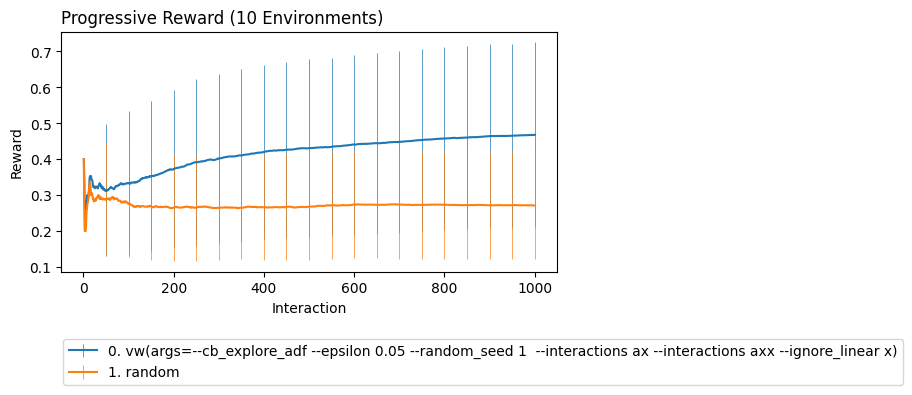

In [48]:
import coba as cb

environments = cb.Environments.from_template('short_experiment.json')
learners     = [cb.VowpalEpsilonLearner(),cb.RandomLearner()]
experiment   = cb.Experiment(environments, learners)

experiment.run(quiet=True).plot_learners(err='se')

## Environment Filters

The Environments api provides tools to modify environments. Individual modifiers are called filters. Here we summarize common filters:

### Filters that apply to all environments

1. `reservoir` -- Randomly subselect interactions in an environment. Does not require loading an entire environment into memory.
2. `shuffle` -- Randomly permute interactions in an environment. Requires loading an entire environment into memory.
3. `take` -- Only keep the first n interactions in an environment.
4. `where` -- Choose which environments to keep based on their characteristics.

In [12]:
import coba as cb

class SimpleEnvironment:
    def read(self):
        return [{'i':i} for i in range(3)]

envs = cb.Environments.from_custom(SimpleEnvironment())

print("------unfiltered------")
print(list(envs[0].read()))

print()
print("------reservoir(2)------")
print(list(envs.reservoir(2)[0].read()))

print()
print("------shuffle()------")
print(list(envs.shuffle()[0].read()))

print()
print("------take(2)------")
print(list(envs.take(2)[0].read()))

print()
print("------where(n_interactions=2)------")
print(list(envs.where(n_interactions=2)[0].read()))

print()
print("------where(n_interactions=3)------")
print(list(envs.where(n_interactions=3)[0].read()))

print()
print("------where(n_interactions=5)------")
print(list(envs.where(n_interactions=5)[0].read()))

print()
print("------where(n_interactions=(2,5))------")
print(list(envs.where(n_interactions=(2,5))[0].read()))

------unfiltered------
[{'i': 0}, {'i': 1}, {'i': 2}]

------reservoir(2)------
[{'i': 2}, {'i': 1}]

------shuffle()------
[{'i': 0}, {'i': 2}, {'i': 1}]

------take(2)------
[{'i': 0}, {'i': 1}]

------where(n_interactions=2)------
[]

------where(n_interactions=3)------
[{'i': 0}, {'i': 1}, {'i': 2}]

------where(n_interactions=5)------
[]

------where(n_interactions=(2,5))------
[{'i': 0}, {'i': 1}, {'i': 2}]


### Filters that apply to context features

1. `scale` -- Pre-condition environment features by centering and scaling.
2. `noise` -- Add noise to an environments features. Particularly useful with synthetic data which is otherwise noiseless.
3. `impute` -- Fill in missing features with summary statistics.

In [36]:
import coba as cb

class SimpleEnvironment:
    def read(self):
        return [{'context':i} for i in range(3)] + [{'context':None}]

envs = cb.Environments.from_custom(SimpleEnvironment())

print("------unfiltered------")
print(list(envs[0].read()))

print()
print("------scale('mean','std')------")
print(list(envs.scale('mean','std')[0].read()))

print()
print("------reservoir(2)------")
print(list(envs.reservoir(2)[0].read()))

print()
print("------shuffle()------")
print(list(envs.shuffle()[0].read()))

print()
print("------take(2)------")
print(list(envs.take(2)[0].read()))

print()
print("------noise()------")
print(list(envs.noise(context=(0,1))[0].read()))

print()
print("------where(n_interactions=2)------")
print(list(envs.where(n_interactions=2)[0].read()))

print()
print("------where(n_interactions=5)------")
print(list(envs.where(n_interactions=5)[0].read()))

print()
print("------impute('mean',indicator=True)------")
print(list(envs.impute('mean',indicator=True)[0].read()))



------unfiltered------
[{'context': 0}, {'context': 1}, {'context': 2}, {'context': None}]

------scale('mean','std')------
[{'context': -1.0}, {'context': 0.0}, {'context': 1.0}, {'context': None}]

------reservoir(2)------
[{'context': None}, {'context': 1}]

------shuffle()------
[{'context': 0}, {'context': None}, {'context': 2}, {'context': 1}]

------take(2)------
[{'context': 0}, {'context': 1}]

------noise()------
[{'context': 0.6259805618684365}, {'context': -1.0118803935399336}, {'context': 2.6130905694888105}, {'context': None}]

------where(n_interactions=2)------
[]

------where(n_interactions=5)------
[]

------impute('mean',indicator=True)------
[{'context': [0, 0]}, {'context': [1, 0]}, {'context': [2, 0]}, {'context': [1.0, 1]}]


### Filters that apply to categorical features
1. `repr` -- Control how categorical features are represented (by default categorical features are one-hot encoded).

In [35]:
import coba as cb

levels  = list(map(str,range(2)))
actions = [cb.Categorical('0',levels),cb.Categorical('1',levels)]

class SimpleEnvironment2:
    def read(self):
        return [{'context':cb.Categorical(str(i),levels), 'actions':actions } for i in range(2)]

envs = cb.Environments.from_custom(SimpleEnvironment2())

print("------unfiltered------")
print(str(list(envs[0].read())))

print()
print("------repr('string','string')------")
print(str(list(envs.repr('string','string')[0].read())))

print()
print("------repr('onehot','string')------")
print(str(list(envs.repr('onehot','string')[0].read())))

------unfiltered------
[{'context': (1, 0), 'actions': [(1, 0), (0, 1)]}, {'context': (0, 1), 'actions': [(1, 0), (0, 1)]}]

------repr('string','string')------
[{'context': '0', 'actions': ['0', '1']}, {'context': '1', 'actions': ['0', '1']}]

------repr('onehot','string')------
[{'context': (1, 0), 'actions': ['0', '1']}, {'context': (0, 1), 'actions': ['0', '1']}]

------dense()------
[{'context': (1, 0), 'actions': [(1, 0), (0, 1)]}, {'context': (0, 1), 'actions': [(1, 0), (0, 1)]}]


### Filters that apply to rewards

1. binary -- Turn rewards into 1/0 with max reward being 1 and all other 0.

In [41]:
import coba as cb

class SimpleEnvironment3:
    def read(self):
        return [{'actions':[1,2], 'rewards':[3,4] } for i in range(2)]

envs = cb.Environments.from_custom(SimpleEnvironment3())

print("------unfiltered------")
print(str(list(envs[0].read())))

print()
print("------binary()------")
print(str(list(envs.binary()[0].read())))

print()
print("------noise(reward=(0,1)).binary()------")
print(str(list(envs.noise(reward=(0,1)).binary()[0].read())))

------unfiltered------
[{'actions': [1, 2], 'rewards': DiscreteReward([[1, 2], [3, 4]])}, {'actions': [1, 2], 'rewards': DiscreteReward([[1, 2], [3, 4]])}]

------binary()------
[{'actions': [1, 2], 'rewards': DiscreteReward([[1, 2], [0, 1]])}, {'actions': [1, 2], 'rewards': DiscreteReward([[1, 2], [0, 1]])}]

------noise(reward=(0,1)).binary()------
[{'actions': [1, 2], 'rewards': DiscreteReward([[1, 2], [1, 0]])}, {'actions': [1, 2], 'rewards': DiscreteReward([[1, 2], [0, 1]])}]


### Filters that apply to sparse context features
1. `dense` -- Turn sparse data into dense data using the 'hashing trick'.


In [2]:
import coba as cb

class SimpleEnvironment4:
    def read(self):
        return [{ 'context': {'a':1,'b':2} } for i in range(2)]

envs = cb.Environments.from_custom(SimpleEnvironment4())

print("------unfiltered------")
print(str(list(envs[0].read())))

print()
print("------dense(5,'lookup')------")
print(str(list(envs.dense(5,'lookup')[0].read())))

print()
print("------dense(5,'hashing')------")
print(str(list(envs.dense(5,'hashing')[0].read())))

------unfiltered------
[{'context': {'a': 1, 'b': 2}}, {'context': {'a': 1, 'b': 2}}]

------dense(5,'lookup')------
[{'context': [1, 0, 0, 0, 2]}, {'context': [1, 0, 0, 0, 2]}]

------dense(5,'hashing')------
[{'context': [0, 2, 1, 0, 0]}, {'context': [0, 2, 1, 0, 0]}]


### Filters that apply to simulated interactions
1. `logged` -- turn simulated interactions into logged interactions using a behavior policy

In [45]:
import coba as cb

class SimpleEnvironment5:
    def read(self):
        return [ { 'actions': [1,2], 'rewards': [3,4] } for i in range(1)]

envs = cb.Environments.from_custom(SimpleEnvironment5())

print("------unfiltered------")
print(str(list(envs[0].read())))

print()
print("------logged(cb.RandomLearner())------")
print(str(list(envs.logged(cb.RandomLearner())[0].read())))

------unfiltered------
[{'actions': [1, 2], 'rewards': DiscreteReward([[1, 2], [3, 4]])}]

------logged(cb.RandomLearner())------
[{'actions': [1, 2], 'rewards': DiscreteReward([[1, 2], [3, 4]]), 'action': 1.0, 'reward': 3, 'probability': 0.5}]


-------------
#### Filters that apply to logged interactions
1. `ope_rewards` -- turn logged interactions into simulated interactions by estimating a reward function

In [1]:
import coba as cb

class SimpleEnvironment6:
    def read(self):
        return [ { 'action': i, 'reward': i*2, 'probability':.5 } for i in range(1,2)]

envs = cb.Environments.from_custom(SimpleEnvironment6())

print("------unfiltered------")
print(str(list(envs[0].read())))

print()
print("------ope_rewards('IPS')------")
print(str(list(envs.ope_rewards('IPS')[0].read())))

------unfiltered------
[{'action': 1, 'reward': 2, 'probability': 0.5}]

------ope_rewards('IPS')------
[{'action': 1, 'reward': 2, 'probability': 0.5, 'rewards': BinaryReward(1, 4.0)}]


## Expansion Filters

A number of environment filters take sequences of values to expand into the Cartesian product of environments.

In [11]:
import coba as cb

print()
print("three environments with distinct linear reward functions")
print("--------------------------------------------------------")
print(cb.Environments.from_linear_synthetic(100, seed=[1,2,5]))

print()
print("three environments with different sets of interactions from the base")
print("--------------------------------------------------------------------")
print(cb.Environments.from_openml(180).reservoir(4000,seeds=[1,2,3]))

print()

print("three environments the same interactions but in different orders")
print("----------------------------------------------------------------")
print(cb.Environments.from_openml(180).reservoir(4000).shuffle(n=3))

print()
print("four environments from two openml datasets and two different selected subsets")
print("-----------------------------------------------------------------------------")
print(cb.Environments.from_openml([180,150]).reservoir(4000,[1,2]))


three environments with distinct linear reward functions
--------------------------------------------------------
1. LinearSynth(A=5,c=5,a=5,R=['a', 'xa'],seed=1) | BatchSafe(Finalize())
2. LinearSynth(A=5,c=5,a=5,R=['a', 'xa'],seed=2) | BatchSafe(Finalize())
3. LinearSynth(A=5,c=5,a=5,R=['a', 'xa'],seed=5) | BatchSafe(Finalize())

three environments with different sets of interactions from the base
--------------------------------------------------------------------
1. Openml(data=180) | Reservoir('reservoir_count': 4000, 'reservoir_seed': 1) | BatchSafe(Finalize())
2. Openml(data=180) | Reservoir('reservoir_count': 4000, 'reservoir_seed': 2) | BatchSafe(Finalize())
3. Openml(data=180) | Reservoir('reservoir_count': 4000, 'reservoir_seed': 3) | BatchSafe(Finalize())

three environments the same interactions but in different orders
----------------------------------------------------------------
1. Openml(data=180) | Reservoir('reservoir_count': 4000, 'reservoir_seed': 1) | Shuffle('s

## Custom Filters

Environment filters are classes with the following interface:

```python
class EnvironmentalFilter:
    def filter(self, interactions:Iterable[Interaction])->Iterable[Interaction]:
        ...
```
`Interaction` is described in more detail in [Interaction.ipynb](Interactions.ipynb). 

### Creating a Custom Filter

Below we create a basic Filter which sets all interaction contexts to 1.

In [14]:
class SetContextToOne:
    def filter(self,interactions):
        for old in interactions:
            new = old.copy()   # we do a shallow copy to make sure we don't contaminate anything
            new['context'] = 1 # we then set the context to 1 on our copy
            yield new          # finally, we yield the new, modified interaction

### Applying a Custom Filter
To apply our filter we use the `cb.Environments.filter` method.

In [26]:
import coba as cb

env = cb.Environments.from_linear_synthetic(100, n_actions=2, n_context_features=1, n_action_features=0)
one = env.filter(SetContextToOne())

print("Before applying our custom filter")
print("---------------------------------")
print(f"  {cb.minimize(next(env[0].read()),2)}")

print()
print("After applying our custom filter")
print("--------------------------------")
print(f"  {cb.minimize(next(one[0].read()),2)}")

Before applying our custom filter
---------------------------------
  {'context': [0.19], 'actions': [[1, 0], [0, 1]], 'rewards': DiscreteReward([[[1, 0], [0, 1]], [0.45448, 0.5144]])}

After applying our custom filter
--------------------------------
  {'context': 1, 'actions': [[1, 0], [0, 1]], 'rewards': DiscreteReward([[[1, 0], [0, 1]], [0.45448, 0.5144]])}


### Adding Parameters to Custom Filters

We can also provide parameters to describe a Filter. In the context of an Experiment these params go to `Result.environments`.

In [24]:
import coba as cb

class ContextToN:
    def __init__(self,N):
        self._N = N
    @property
    def params(self):
        return {'N':self._N}
    def filter(self,interactions):
        for old in interactions:
            yield {**old, 'context':self._N}

env = cb.Environments.from_linear_synthetic(100, n_actions=2, n_context_features=1, n_action_features=1)
two = env.filter(ContextToN(2))

print("Environment parameters before filtering")
print("---------------------------------------")
print(f"  {env[0].params}")

print()
print("Environment parameters after filtering")
print("--------------------------------------")
print(f"  {two[0].params}")

Environment parameters before filtering
---------------------------------------
  {'env_type': 'LinearSynthetic', 'reward_features': ['a', 'xa'], 'n_coeff': 5, 'n_actions': 2, 'seed': 1}

Environment parameters after filtering
--------------------------------------
  {'env_type': 'LinearSynthetic', 'reward_features': ['a', 'xa'], 'n_coeff': 5, 'n_actions': 2, 'seed': 1, 'N': 2}
